In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26
PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


In [11]:
import tensorflow as tf
from tensorflow.keras import layers

# Define your strength values
strength = [0.4, 0.4, 0.4, 0.1]

# Define the augmentation layers
random_flip = layers.RandomFlip(mode="horizontal_and_vertical")
random_crop = layers.RandomCrop(CROP_TO, CROP_TO)

# Use TensorFlow's built-in functions for brightness and contrast adjustments
def random_brightness(image, delta):
    return tf.image.adjust_brightness(image, delta)

def random_contrast(image, lower, upper):
    return tf.image.adjust_contrast(image, tf.random.uniform([], lower, upper))

# Replace RandomSaturation and RandomHue with custom functions
def random_saturation(image, lower, upper):
    factor = tf.random.uniform([], lower, upper)
    return tf.image.adjust_saturation(image, factor)

def random_hue(image, max_delta):
    return tf.image.adjust_hue(image, max_delta)

# Grayscale conversion using TensorFlow's built-in functions
def grayscale(image):
    return tf.image.rgb_to_grayscale(image)

# Define the augmentation functions
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = random_flip(image)
    image = random_crop(image)
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = random_brightness(x, 0.8 * strength[0])
    x = random_contrast(x, 1 - 0.8 * strength[1], 1 + 0.8 * strength[1])
    x = random_saturation(x, 0.5 - 0.8 * strength[2], 0.5 + 0.8 * strength[2])
    x = random_hue(x, 0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = grayscale(x)
    x = tf.image.grayscale_to_rgb(x)
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image


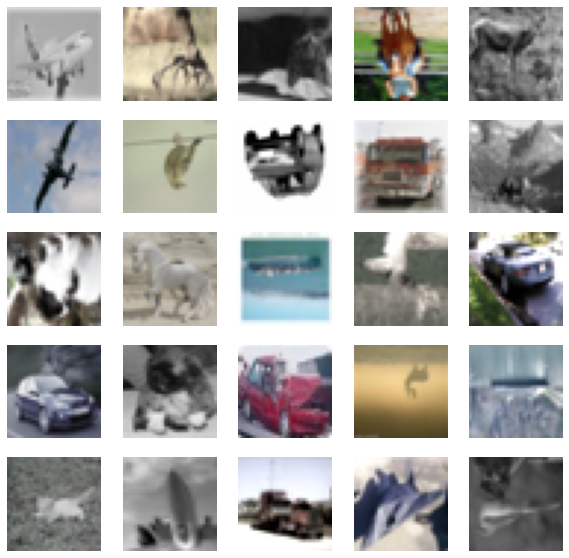

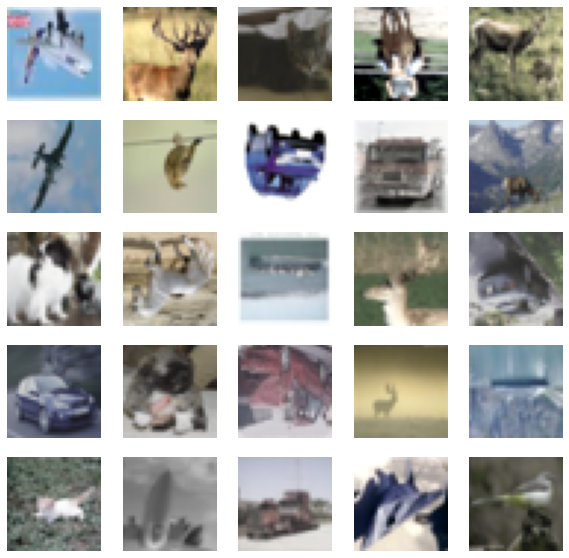

In [12]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.applications import ResNet50V2

# Define constants
PROJECT_DIM = 128  # Projection dimension
WEIGHT_DECAY = 1e-4  # Weight decay for regularization
LATENT_DIM = 64  # Latent dimension for the predictor

def get_encoder():
    # Input and backbone.
    inputs = layers.Input((32, 32, 3))
    
    # Use ResNet50V2 as the backbone but change the input shape to (32, 32, 3)
    base_model = ResNet50V2(include_top=False, weights=None, input_tensor=inputs, input_shape=(32, 32, 3))
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(base_model.output)

    # Projection head
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    
    return models.Model(inputs, outputs, name="encoder")

def get_predictor():
    model = models.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


In [22]:
import tensorflow as tf

def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.linalg.l2_normalize(p, axis=1)
    z = tf.linalg.l2_normalize(z, axis=1)
    
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum(p * z, axis=1))


In [16]:
class SimSiam(keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [25]:
import tensorflow as tf
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

# Assuming x_train, EPOCHS, BATCH_SIZE, and ssl_ds are already defined

# Create an Adam optimizer.
optimizer = tf.keras.optimizers.Adam()

# Compile the model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=optimizer)
history = simsiam.fit(ssl_ds, epochs=50)

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Training Loss")
plt.show()


Epoch 1/100
391/391 [==============================] - 115s 273ms/step - loss: -0.9638
Epoch 2/100
391/391 [==============================] - 112s 285ms/step - loss: -1.0000
Epoch 3/100
391/391 [==============================] - 116s 296ms/step - loss: -1.0000
Epoch 4/100
391/391 [==============================] - 118s 300ms/step - loss: -1.0000
Epoch 5/100
391/391 [==============================] - 118s 300ms/step - loss: -1.0000
Epoch 6/100
391/391 [==============================] - 112s 287ms/step - loss: -1.0000
Epoch 7/100
391/391 [==============================] - 114s 292ms/step - loss: -1.0000
Epoch 8/100
391/391 [==============================] - 121s 310ms/step - loss: -1.0000
Epoch 9/100
391/391 [==============================] - 115s 294ms/step - loss: -1.0000
Epoch 10/100
119/391 [========>.....................] - ETA: 1:15 - loss: -1.0000

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Constants
CROP_TO = 32  # Crop size set to 32x32
BATCH_SIZE = 64  # Define your batch size
EPOCHS = 20  # Define the number of epochs
AUTO = tf.data.experimental.AUTOTUNE  # For optimized performance

# Create labeled `Dataset` objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle, batch, and prefetch dataset. Apply random crops only to the training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (tf.image.random_crop(x, [CROP_TO, CROP_TO, 3]), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet50V2.
backbone = models.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# Create a linear classifier and train it.
backbone.trainable = True
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = models.Model(inputs, outputs, name="linear_model")

# Compile the model using the Adam optimizer
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=optimizers.Adam(),
)

# Train the model
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=50)

# Evaluate the model
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
